In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools


In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [3]:
covid_df  = pd.read_csv('northcarolina_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)

train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]
covid_train = covid_train.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_test = covid_test.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [4]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Baseline Univariate

In [5]:
prop_base = Prophet()
prop_base.fit(covid_train)
prop_base_df = prop_base.make_future_dataframe(periods=len(covid_test))
prop_base_pred = prop_base.predict(prop_base_df)
prop_base_train = prop_base.predict(covid_train)
prop_base_test = prop_base.predict(covid_test)

20:16:18 - cmdstanpy - INFO - Chain [1] start processing
20:16:18 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

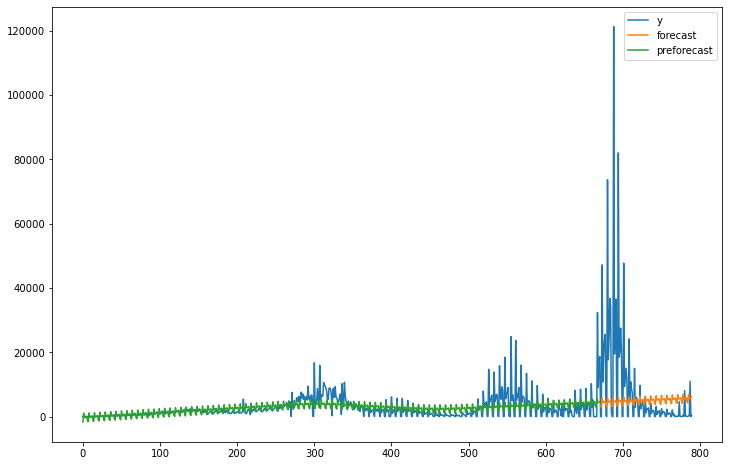

In [6]:
prophet_df_base = pd.DataFrame(covid_df)
prophet_df_base = prophet_df_base.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_base['ds'] = pd.to_datetime(prophet_df_base['ds'])

prophet_df_base['forecast'] = prop_base_test['yhat']
length1 = len(prophet_df_base) - len(prop_base_test)
forecast1 = pd.concat([pd.Series([np.nan] * length1), prop_base_test['yhat']], ignore_index=True)
prophet_df_base['forecast'] = forecast1

prophet_df_base['preforecast']=prop_base_train['yhat']

prophet_df_base[['y','forecast', 'preforecast']].plot(figsize=(12,8))

Text(0, 0.5, 'Count')

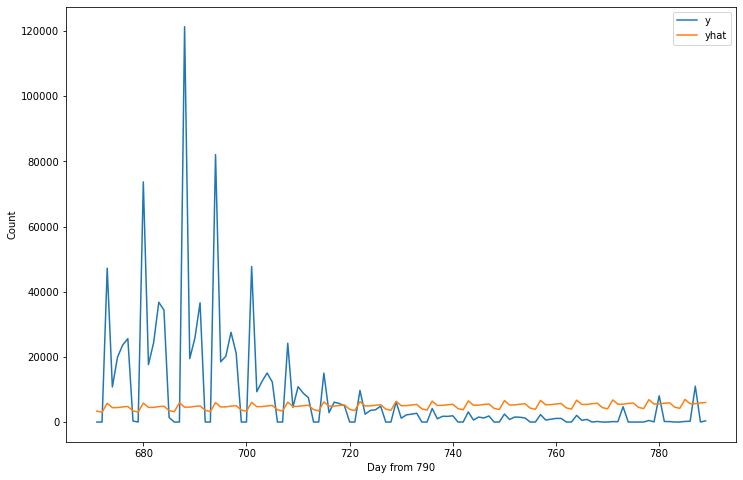

In [7]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_base_test['yhat'].values
graph_df[['y','yhat']].plot(figsize=(12,8))
plt.xlabel('Day from 790')
plt.ylabel('Count')

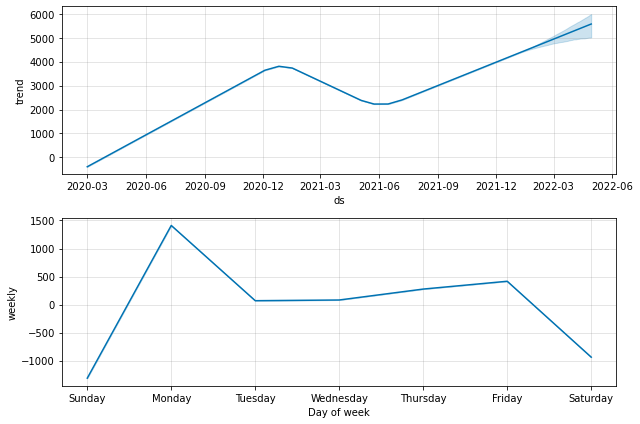

In [8]:
future_baseline = prop_base.make_future_dataframe(periods=len(covid_test))
future_baseline['ds'] = pd.to_datetime(future_baseline['ds'])
forecast_baseline = prop_base.predict(future_baseline)
prop_base.plot_components(forecast_baseline);

In [9]:
performance_baseline = pd.concat([covid_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(16)], keys=['ds'])

In [10]:
print('MAE = ', mean_absolute_error(performance_baseline['y'], performance_baseline['yhat']))
print('MASE = ', mase(performance_baseline['y'], performance_baseline['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_baseline['yhat'], performance_baseline['y'])))

MAE =  8797.526662462185
MASE =  0.945454546106634
RMSE =  17410.206328195225


## Tuned Univariate

In [11]:
prop_base.changepoints

21    2020-03-22
43    2020-04-13
64    2020-05-04
86    2020-05-26
107   2020-06-16
128   2020-07-07
150   2020-07-29
171   2020-08-19
193   2020-09-10
214   2020-10-01
235   2020-10-22
257   2020-11-13
278   2020-12-04
300   2020-12-26
321   2021-01-16
342   2021-02-06
364   2021-02-28
385   2021-03-21
407   2021-04-12
428   2021-05-03
449   2021-05-24
471   2021-06-15
492   2021-07-06
514   2021-07-28
535   2021-08-18
Name: ds, dtype: datetime64[ns]

In [12]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window updated to 2021-22 since the 2020 one is out of our window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [13]:

'''tss = TimeSeriesSplit(n_splits = 5)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

for params in all_params:
    m = Prophet(**params).fit(covid_train)  
    df_cv = cross_validation(m, initial='200 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)'''

'tss = TimeSeriesSplit(n_splits = 5)\n\nparam_grid = {  \n    \'changepoint_prior_scale\': [0.001, 0.01, 0.1, 0.5],\n    \'seasonality_prior_scale\': [0.01, 0.1, 1.0, 10.0],\n    \'holidays_prior_scale\': [0.01, 0.1, 1.0, 10.0],\n    \'seasonality_mode\': [\'additive\', \'multiplicative\'],\n}\n\nall_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]\nrmses = []  \n\nfor params in all_params:\n    m = Prophet(**params).fit(covid_train)  \n    df_cv = cross_validation(m, initial=\'200 days\', period=\'20 days\', horizon = \'10 days\', parallel="processes")\n    df_p = performance_metrics(df_cv, rolling_window=1)\n    rmses.append(df_p[\'rmse\'].values[0])\n\ntuning_results = pd.DataFrame(all_params)\ntuning_results[\'rmse\'] = rmses\nprint(tuning_results)'

In [14]:
#best_params = all_params[np.argmin(rmses)]
#print(best_params)

In [15]:
prophet_tuned = Prophet(yearly_seasonality=True, n_changepoints=25, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, holidays_prior_scale=0.01, seasonality_mode='multiplicative')
prophet_tuned.add_country_holidays(country_name='US')

prophet_tuned.fit(covid_train)
prop_season_train = prophet_tuned.predict(covid_train)
prop_season_test = prophet_tuned.predict(covid_test)

20:16:20 - cmdstanpy - INFO - Chain [1] start processing
20:16:20 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

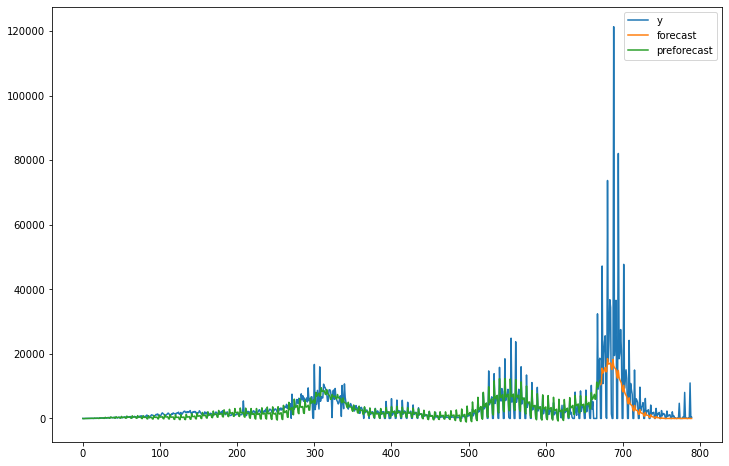

In [16]:
prophet_df_season = pd.DataFrame(covid_df)
prophet_df_season = prophet_df_season.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_season['ds'] = pd.to_datetime(prophet_df_season['ds'])

prophet_df_season['forecast'] = prop_season_test['yhat']
length2 = len(prophet_df_season) - len(prop_season_test)
forecast2 = pd.concat([pd.Series([np.nan] * length2), prop_season_test['yhat']], ignore_index=True)
prophet_df_season['forecast'] = forecast2
prophet_df_season['forecast'] = np.clip(prophet_df_season['forecast'], 0, None)


prophet_df_season['preforecast']=prop_season_train['yhat']

prophet_df_season[['y','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:>

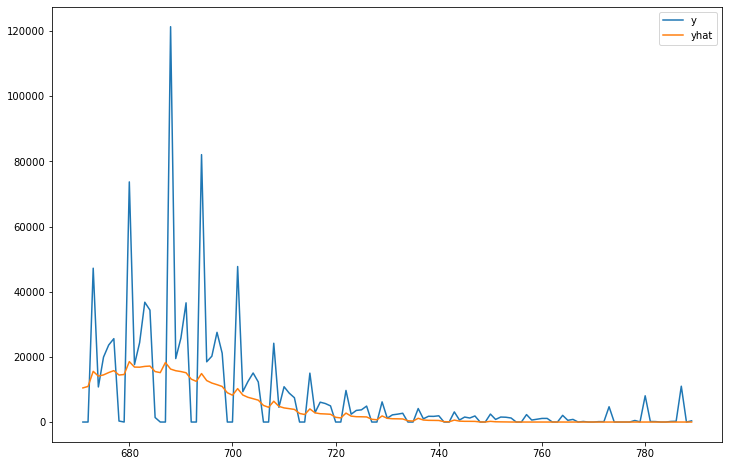

In [17]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_season_test['yhat'].values
graph_df['yhat'] = np.clip(graph_df['yhat'], 0, None)
graph_df[['y','yhat']].plot(figsize=(12,8))

In [18]:
tuned_df = prophet_tuned.make_future_dataframe(periods=len(covid_test))
tuned_df['ds'] = pd.to_datetime(tuned_df['ds'])
forecast_tuned = prop_base.predict(tuned_df)

tunned_performance = pd.concat([covid_test, forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(119)], keys=['ds'])
print('MAE = ', mean_absolute_error(tunned_performance['y'], tunned_performance['yhat']))
print('MASE = ', mase(tunned_performance['y'], tunned_performance['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(tunned_performance['yhat'], tunned_performance['y'])))

MAE =  6363.475240715336
MASE =  0.683871368192876
RMSE =  14766.728580961018


## Baseline Multivariate 

In [ ]:
import os
os._exit(00)

In [1]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb

from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [3]:
covid_df = pd.read_csv('nc_multi_df.csv', parse_dates=['Date'])
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_df

,ds,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,Series_Complete_5to17,...,new_cases_50_lag,new_cases_150_lag,new_cases_350_lag,new_deaths_1_lag,new_deaths_2_lag,new_deaths_3_lag,new_deaths_4_lag,new_deaths_7_lag,new_deaths_30_lag,new_deaths_50_lag
0,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,9690.0,8504576.0,8500940.0,8228999.0,7716931.0,2139685.0,6190882.0,6188949.0,597215.0,...,0.0,0.0,3289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786,2022-04-26,9690.0,8506289.0,8502651.0,8230670.0,7718549.0,2140533.0,6193015.0,6191080.0,597310.0,...,4143.0,0.0,1017.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0
787,2022-04-27,9690.0,8508946.0,8505294.0,8233236.0,7720994.0,2141809.0,6196021.0,6194074.0,597477.0,...,993.0,0.0,1480.0,0.0,0.0,0.0,0.0,29.0,16.0,15.0
788,2022-04-28,9690.0,8514501.0,8510814.0,8238548.0,7726093.0,2144490.0,6201496.0,6199525.0,597756.0,...,1766.0,8154.0,1353.0,42.0,0.0,0.0,0.0,0.0,4.0,47.0


In [4]:
train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [5]:
covid_train = covid_train[['ds', 'y', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']]
covid_test = covid_test[['ds', 'y', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']]

In [6]:
multi_prop = Prophet(yearly_seasonality=True, weekly_seasonality=True)

regressors = ['new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']
for regressor in regressors:
    multi_prop.add_regressor(regressor, standardize=False)
    
multi_prop.fit(covid_train)

20:16:32 - cmdstanpy - INFO - Chain [1] start processing
20:16:33 - cmdstanpy - INFO - Chain [1] done processing
20:16:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:16:33 - cmdstanpy - INFO - Chain [1] start processing
20:16:38 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future_multi = multi_prop.make_future_dataframe(periods=len(covid_test))
future_multi = pd.merge(future_multi, covid_df[['ds', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']], on='ds', how='inner')
forecast_multi = multi_prop.predict(future_multi)
forecast_multi['yhat'] = np.clip(forecast_multi['yhat'], 0, None)


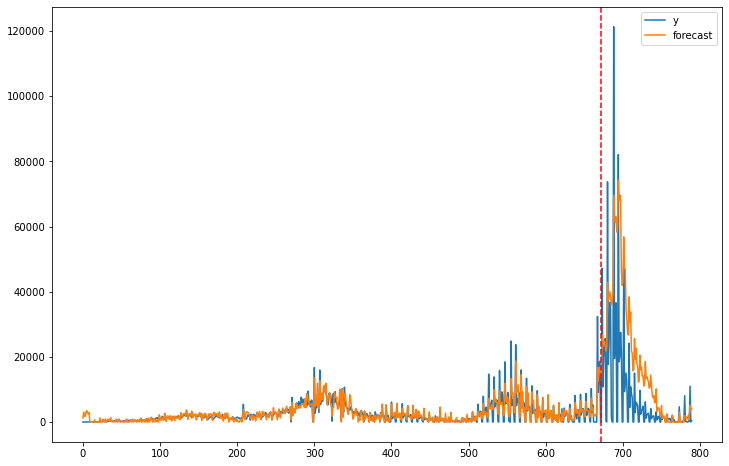

In [8]:
prophet_df_multi = pd.DataFrame(covid_df)
prophet_df_multi = prophet_df_multi.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi['ds'] = pd.to_datetime(prophet_df_multi['ds'])

prophet_df_multi['forecast']=forecast_multi['yhat']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

In [9]:
graph_df = pd.DataFrame(covid_test['y'])
#graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_cases_50_std,PEOPLE_DEATH_NEW_COUNT,relative_humidity,average_temperature_celsius,new_cases_10_std,new_hospitalized_patients,Series_Complete_5Plus,new_deaths_10_mean,current_intensive_care_patients,new_cases_10_min,new_cases_10_mean,new_cases_10_max,minimum_temperature_celsius
671,2022-01-01,0,5873.068748,0,80.851400,20.383333,11474.198495,357.0,5797842.0,19.3,565.0,0.0,7773.0,32389.0,15.294444
672,2022-01-02,0,5873.068748,0,84.067024,19.522222,11474.198495,394.0,5797842.0,19.3,615.0,0.0,7773.0,32389.0,16.611111
673,2022-01-03,47202,8488.656546,31,88.438403,10.033333,16520.487993,429.0,5802003.0,22.4,624.0,0.0,12493.2,47202.0,1.944444
674,2022-01-04,10763,8533.452562,37,68.938556,0.750000,15957.123246,467.0,5804098.0,26.1,649.0,0.0,13569.5,47202.0,-3.966667
675,2022-01-05,19919,8788.383657,48,70.081309,5.250000,15304.959996,482.0,5808096.0,30.9,664.0,0.0,15561.4,47202.0,-2.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,188,1493.699202,0,62.630500,20.905556,2515.544730,53.0,6188949.0,2.9,42.0,0.0,907.2,8054.0,13.166667
786,2022-04-26,229,1426.590107,0,68.249504,21.094444,2507.397653,52.0,6191080.0,2.9,46.0,0.0,930.1,8054.0,15.394444
787,2022-04-27,10992,2016.061337,42,45.778288,15.505556,4012.172120,66.0,6194074.0,7.1,41.0,0.0,2029.3,10992.0,6.994444
788,2022-04-28,0,2019.980423,0,49.423702,14.155556,4035.569822,50.0,6199525.0,7.1,42.0,0.0,1981.3,10992.0,5.538889


In [10]:
graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_cases_50_std,PEOPLE_DEATH_NEW_COUNT,relative_humidity,average_temperature_celsius,new_cases_10_std,new_hospitalized_patients,Series_Complete_5Plus,new_deaths_10_mean,current_intensive_care_patients,new_cases_10_min,new_cases_10_mean,new_cases_10_max,minimum_temperature_celsius
671,2022-01-01,0,5873.068748,0,80.851400,20.383333,11474.198495,357.0,5797842.0,19.3,565.0,0.0,7773.0,32389.0,15.294444
672,2022-01-02,0,5873.068748,0,84.067024,19.522222,11474.198495,394.0,5797842.0,19.3,615.0,0.0,7773.0,32389.0,16.611111
673,2022-01-03,47202,8488.656546,31,88.438403,10.033333,16520.487993,429.0,5802003.0,22.4,624.0,0.0,12493.2,47202.0,1.944444
674,2022-01-04,10763,8533.452562,37,68.938556,0.750000,15957.123246,467.0,5804098.0,26.1,649.0,0.0,13569.5,47202.0,-3.966667
675,2022-01-05,19919,8788.383657,48,70.081309,5.250000,15304.959996,482.0,5808096.0,30.9,664.0,0.0,15561.4,47202.0,-2.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,188,1493.699202,0,62.630500,20.905556,2515.544730,53.0,6188949.0,2.9,42.0,0.0,907.2,8054.0,13.166667
786,2022-04-26,229,1426.590107,0,68.249504,21.094444,2507.397653,52.0,6191080.0,2.9,46.0,0.0,930.1,8054.0,15.394444
787,2022-04-27,10992,2016.061337,42,45.778288,15.505556,4012.172120,66.0,6194074.0,7.1,41.0,0.0,2029.3,10992.0,6.994444
788,2022-04-28,0,2019.980423,0,49.423702,14.155556,4035.569822,50.0,6199525.0,7.1,42.0,0.0,1981.3,10992.0,5.538889


,ds,y,new_cases_50_std,PEOPLE_DEATH_NEW_COUNT,relative_humidity,average_temperature_celsius,new_cases_10_std,new_hospitalized_patients,Series_Complete_5Plus,new_deaths_10_mean,current_intensive_care_patients,new_cases_10_min,new_cases_10_mean,new_cases_10_max,minimum_temperature_celsius
671,2022-01-01,0,5873.068748,0,80.851400,20.383333,11474.198495,357.0,5797842.0,19.3,565.0,0.0,7773.0,32389.0,15.294444
672,2022-01-02,0,5873.068748,0,84.067024,19.522222,11474.198495,394.0,5797842.0,19.3,615.0,0.0,7773.0,32389.0,16.611111
673,2022-01-03,47202,8488.656546,31,88.438403,10.033333,16520.487993,429.0,5802003.0,22.4,624.0,0.0,12493.2,47202.0,1.944444
674,2022-01-04,10763,8533.452562,37,68.938556,0.750000,15957.123246,467.0,5804098.0,26.1,649.0,0.0,13569.5,47202.0,-3.966667
675,2022-01-05,19919,8788.383657,48,70.081309,5.250000,15304.959996,482.0,5808096.0,30.9,664.0,0.0,15561.4,47202.0,-2.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,188,1493.699202,0,62.630500,20.905556,2515.544730,53.0,6188949.0,2.9,42.0,0.0,907.2,8054.0,13.166667
786,2022-04-26,229,1426.590107,0,68.249504,21.094444,2507.397653,52.0,6191080.0,2.9,46.0,0.0,930.1,8054.0,15.394444
787,2022-04-27,10992,2016.061337,42,45.778288,15.505556,4012.172120,66.0,6194074.0,7.1,41.0,0.0,2029.3,10992.0,6.994444
788,2022-04-28,0,2019.980423,0,49.423702,14.155556,4035.569822,50.0,6199525.0,7.1,42.0,0.0,1981.3,10992.0,5.538889


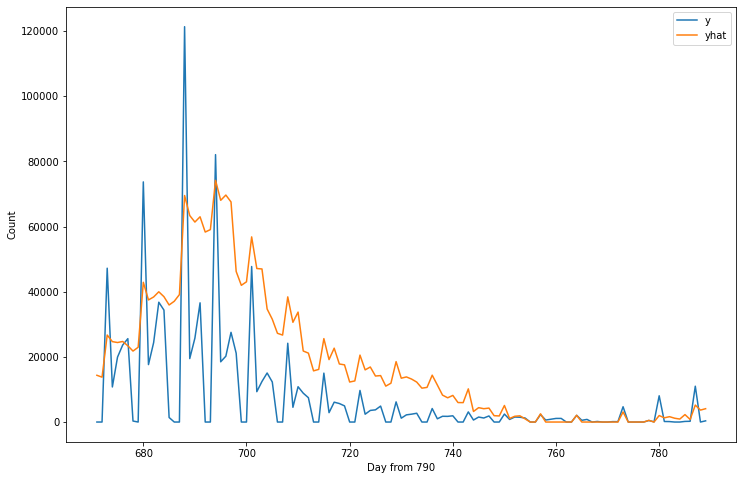

In [11]:
graph_df[['y','yhat']].plot(figsize=(12,8))
plt.xlabel('Day from 790')
plt.ylabel('Count')
covid_test

In [12]:
performance_multi = pd.merge(covid_test, forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE = ', mean_absolute_error(performance_multi['y'], performance_multi['yhat']))
print('MASE = ', mase(performance_multi['y'], performance_multi['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE =  12494.936344029204
MASE =  1.342808589621162
RMSE =  18967.392643904466


## Tuned Multivariate

In [13]:
'''
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

for params in all_params:
    m = Prophet(**params).fit(covid_train)  
    df_cv = cross_validation(m, initial='200 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
'''

'\nimport itertools\nimport numpy as np\nimport pandas as pd\nfrom prophet.diagnostics import cross_validation\nfrom prophet.diagnostics import performance_metrics\n\n\nparam_grid = {  \n    \'changepoint_prior_scale\': [0.001, 0.01, 0.1, 0.5],\n    \'seasonality_prior_scale\': [0.01, 0.1, 1.0, 10.0],\n    \'holidays_prior_scale\': [0.01, 0.1, 1.0, 10.0],\n    \'seasonality_mode\': [\'additive\', \'multiplicative\'],\n}\n\nall_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]\nrmses = [] \n\nfor params in all_params:\n    m = Prophet(**params).fit(covid_train)  \n    df_cv = cross_validation(m, initial=\'200 days\', period=\'20 days\', horizon = \'10 days\', parallel="processes")\n    df_p = performance_metrics(df_cv, rolling_window=1)\n    rmses.append(df_p[\'rmse\'].values[0])\n\ntuning_results = pd.DataFrame(all_params)\ntuning_results[\'rmse\'] = rmses\nprint(tuning_results)\n'

In [14]:
#best_params = all_params[np.argmin(rmses)]
#print(best_params)

In [15]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

events = pd.concat((COVID, superbowl))
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [16]:
#model_holiday_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=True, 
#                              changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, 
#                              holidays_prior_scale=0.01, seasonality_mode='additive', 
 #                             n_changepoints=25)
model_holiday_tuned = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, 
                              holidays_prior_scale=0.01, seasonality_mode='multiplicative')
model_holiday_tuned.add_country_holidays(country_name='US')

regressors = ['new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']
for regressor in regressors:
    model_holiday_tuned.add_regressor(regressor, standardize=False)

model_holiday_tuned.fit(covid_train)

20:16:40 - cmdstanpy - INFO - Chain [1] start processing
20:16:40 - cmdstanpy - INFO - Chain [1] done processing
20:16:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:16:40 - cmdstanpy - INFO - Chain [1] start processing
20:16:43 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future_holiday_tuned = model_holiday_tuned.make_future_dataframe(periods=len(covid_test))

future_holiday_tuned = pd.merge(future_holiday_tuned, covid_df[['ds', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']], on='ds', how='inner')
future_holiday_tuned = future_holiday_tuned.fillna(method='ffill')

forecast_holiday_tuned = model_holiday_tuned.predict(future_holiday_tuned)
forecast_holiday_tuned['yhat'] = np.clip(forecast_holiday_tuned['yhat'], 0, None)

In [18]:
performance_holiday_tuned = pd.merge(covid_test, forecast_holiday_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE =', mean_absolute_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('MASE = ', mase(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE = 18984.814934791826
MASE =  2.0402643010653336
RMSE =  18967.392643904466


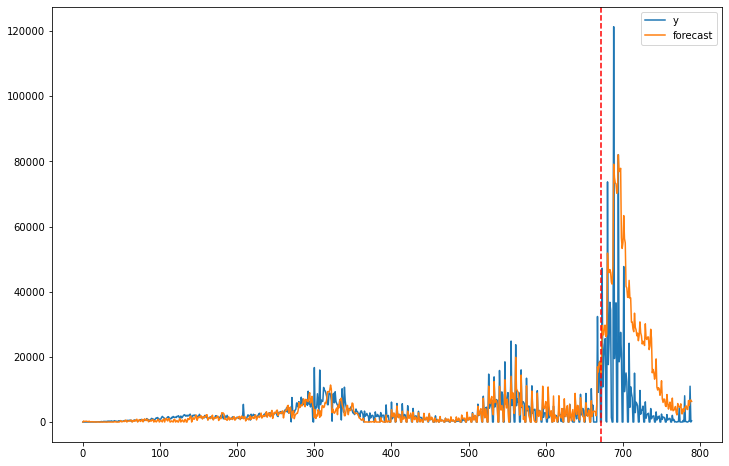

In [19]:
prophet_df_multi_tuned = pd.DataFrame(covid_df)
prophet_df_multi_tuned = prophet_df_multi_tuned.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi_tuned['ds'] = pd.to_datetime(prophet_df_multi_tuned['ds'])

prophet_df_multi_tuned['forecast']=forecast_holiday_tuned['yhat']

prophet_df_multi_tuned[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

<AxesSubplot:>

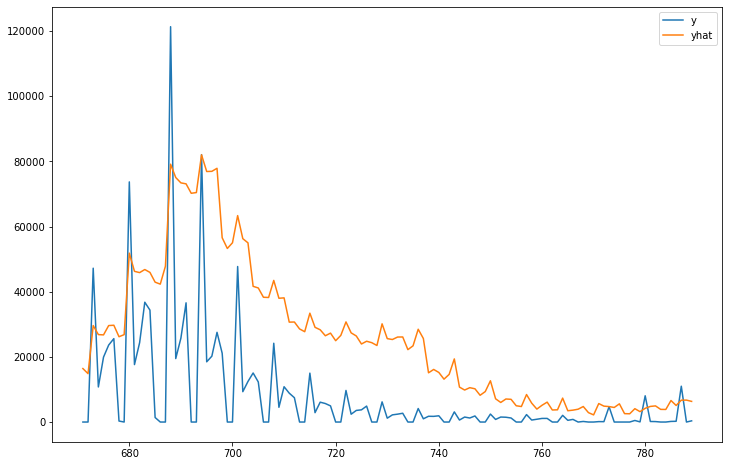

In [20]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prophet_df_multi_tuned['forecast'].tail(119).values
graph_df[['y','yhat']].plot(figsize=(12,8))